In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import random
import copy

In [11]:
class Problem:

    startState = (1,1)   # (x, y) class variable shared by all instances
    movesEffects = {"L":(-1,0), "R":(+1,0), "U":(0,+1), "D":(0,-1),}

    def __init__(self, dimension=(4,3), walls=[], penaltyState=[]):
        self.dimension = dimension
        self.walls = walls
        self.goalState = (dimension[0], dimension[1])    # instance variable unique to each instance
        self.penaltyState = penaltyState
        
        self.xMin, self.xMax = 1, dimension[0]
        self.yMin, self.yMax = 1, dimension[1]        
    
    def getLegalActions(self, state):
        validMoves = []
        for k,v in self.movesEffects.items():
            result_x = state[0] + v[0]
            result_y = state[1] + v[1]
            
            isValid = True

            if (result_x, result_y) in self.walls:
                isValid = False
            if result_x < self.xMin or result_x > self.xMax:
                isValid = False
            if result_y < self.yMin or result_y > self.yMax:
                isValid = False
            if isValid == True:
                validMoves.append(k)
        if not validMoves:
            print("no legal move for {} ".format(state))
        return validMoves
    
    def move(self, state, action):
        (new_x, new_y) = (-1,-1)
        if action in self.getLegalActions(state):
            new_x = state[0] + self.movesEffects[action][0]
            new_y = state[1] + self.movesEffects[action][1]
        if (new_x, new_y) == (-1,-1):
            print("Error, invalid move!")
        return (new_x, new_y)
    
    def isGoal(self, state):
        return state == self.goalState
    
    def findPathCost(self, path):
        return len(path)
    
    def findStepCost(self, state, action):
        return 1.0


In [12]:
class SearchAgent:

    def __init__(self, p, method='bfs'):
        self.problem = p
        self.method = method
        self.frontierList = [(self.problem.startState, [], 0)] #(path end state, path list, path cost)
        self.exploredList = []
        self.visitedList = []
        self.path = []
    
    def moveChoice(self):
        if self.method == 'bfs':
            self.frontierList.sort(key=lambda x: x[2]) #sort the frontier list by path cost
            pathstep = self.frontierList.pop(0) #pop the smallest path cost item
        elif self.method == 'dfs':
            self.frontierList = sorted(self.frontierList, key=lambda x: x[2])[::-1] 
                #sort the frontier list by path cost
            pathstep = self.frontierList.pop(0)
        elif self.method == 'astar':
            min_total_cost = float(np.inf)
            min_pop_index = None
            for i in range(len(self.frontierList)):
                actual_cost = self.frontierList[i][2]
                # use manhattan distance as an estimation
                heuristic_cost = np.sqrt(np.sum(np.square(np.array(self.frontierList[i][0]) 
                                                          - np.array(self.problem.goalState))))
                total_cost = actual_cost + heuristic_cost
                if total_cost < min_total_cost:
                    min_total_cost = total_cost
                    min_pop_index = i
            pathstep = self.frontierList.pop(min_pop_index)

        return pathstep, self.frontierList 
    
    def findPaths(self, printGoal=False):

        while self.frontierList:

            pathstep, self.frontierList = self.moveChoice() 
            #different method only affect the choice of next node to explore

            s = pathstep[0] #state
            self.path = pathstep[1] #the active path

            if self.problem.isGoal(s):
                if printGoal:
                    print("{} no of steps: {}".format(method, len(path)))
                    print("Path:{}".format(path), end='\n')
                return self.path, self.visitedList  

            legalActionsList = self.problem.getLegalActions(s) # get legal moves

            self.exploredList.append(s)

            for a in legalActionsList:

                next_end = self.problem.move(s,a) #assume we take the move, what would be the future state?

                if next_end not in self.exploredList and next_end not in [x[0] for x in self.frontierList]:
                    #make sure we are not going back to explored node and no duplication in frontierList

                    if len(self.path) == 0: #make sure startState is included in the path
                        self.path.append(self.problem.startState)
                        self.visitedList.append(self.problem.startState) #for visual graph

                    next_path = copy.deepcopy(self.path)
                    next_path.append(next_end) #keep track on how did we reach this frontier node

                    self.frontierList.append((next_end, next_path, self.problem.findPathCost(next_path))) 

                    self.visitedList.append(next_end) # for visualization

        return self.path, self.visitedList
    
    def path2grid(self):
        assert(len(self.path) > 0)
        
        data = np.zeros(self.problem.dimension)
        
        for w in self.problem.walls:
            data[w[1]-1,w[0]-1] += 1.0

        for v in self.visitedList:
            data[v[1]-1,v[0]-1] += 0.2

        for pa in self.path:
            data[pa[1]-1,pa[0]-1] += 0.3
            
        data = np.flip(data,axis=0)
        
        return data

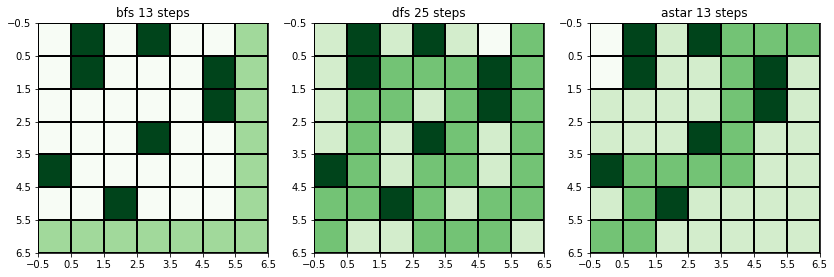

In [13]:
dimension = (7,7)
p = Problem(dimension,
            walls=[(1,3),
                   (2,6),(2,7),
                   (3,2),
                   (4,4),(4,7),
                   #(5,6),
                   (6,5),(6,6),
                  ]           
           )
searchMethodList = ['bfs','dfs','astar']

fig, axs = plt.subplots(1,len(searchMethodList), figsize=(14,6)) 

for i in range(len(searchMethodList)):
    s = SearchAgent(p, searchMethodList[i])
    path, visitedList = s.findPaths()
    data = s.path2grid()
    
    axs[i].imshow(data, cmap='Greens')

    # draw gridlines
    axs[i].set(title= str(searchMethodList[i]) + ' ' + str(len(path)) + ' steps')
    axs[i].grid(which='major', axis='both', linestyle='-', color='k', linewidth=2)
    axs[i].set_xticks(np.arange(-.5, dimension[0], 1));
    axs[i].set_yticks(np.arange(-.5, dimension[1], 1));
    
plt.show()

In [14]:
####################################################################

In [533]:
def showSearchPolicy(px, sA, initialState = (1,1), title=''):
    
    endStateReached = False
    searchPath = []

    currentState = initialState
    searchPath.append(currentState)
    counter = 0
    while not endStateReached and counter < 10000:
        optimalAct, optimalQscore = sA.getOptimalAction(currentState, offPolicyThreshold=0.0)
        nextState = px.move(currentState, optimalAct, probabilistic=True)

        currentState = nextState
        searchPath.append(currentState)

        if currentState in px.goalState: #once reached the goal the search ended
            endStateReached = True
        
        counter += 1

    displayRLMaze(px,sA,searchPath, title)

In [534]:
from matplotlib.font_manager import FontProperties

def displayRLMaze(p1, sA, visitedPath=[], title=''):
    font0 = FontProperties()
    font1 = font0.copy()
    font1.set_size(20)
    font1.set_weight('bold')
    alignment = {'horizontalalignment': 'center', 'verticalalignment': 'center'}
    dir2ArrowsMap = {'L':'◀','R':'►','U':'▲','D':'▼'}

    data = np.zeros([p1.dimension[1], p1.dimension[0]])

    fig, ax  = plt.subplots(1,1, figsize=(5,5)) 

    for w in p1.walls:
        data[w[1]-1,w[0]-1] = 0

    for v in visitedPath:
        data[v[1]-1,v[0]-1] += 0.01

    data = np.flip(data,axis=0)

    ax.imshow(data, cmap='Greens')
    
    plotYAxisConvertor = list(np.arange(0,p1.dimension[1]))[::-1]

    for i in range(p1.dimension[0]):
        for j in range(p1.dimension[1]):        

            if (i+1,j+1) in p1.goalState:
                """
                The text plot coordination would be (0,1)
                0000
                1000
                0000
                """
                uj = plotYAxisConvertor.index(j)
                plt.text(i,uj,'◎', color='k', fontproperties=font1, **alignment)
            elif (i+1,j+1) in p1.penaltyState:
                uj = plotYAxisConvertor.index(j)
                plt.text(i,uj,'☠', color='k', fontproperties=font1, **alignment)
            elif (i+1,j+1) in p1.walls:
                uj = plotYAxisConvertor.index(j)
                plt.text(i,uj,'X', color='k', fontproperties=font1, **alignment)
            else:
                qScoreMax = -np.Inf
                MaxDir = None
                for keys, values in sA.qScore[(i+1,j+1)].items():
                    if values > qScoreMax:
                        qScoreMax = values
                        MaxDir = keys
                uj = plotYAxisConvertor.index(j)
                plt.text(i,uj,dir2ArrowsMap[MaxDir], color='r', fontproperties=font1, **alignment) 
                
    # draw gridlines
    ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=2)
    ax.set(title=title)
    ax.set_xticks(np.arange(-.5, p1.dimension[0], 1));
    ax.set_yticks(np.arange(-.5, p1.dimension[1], 1));

In [535]:
class RL_Problem():
    legalMoves = ['L','R','U','D']
    moveEffect = {'L':(-1,0), 'R':(+1,0), 'U':(0,+1), 'D':(0,-1)}
    step_reward = {}
    moveProbability = [0.8,0.1,0.1]
    
    def __init__(self, dimension = (4,3), walls = [(2,2)], penaltyState = [],
                 goalStateReward=1.0, penaltyStateReward=-1.0, global_step_cost=-0.04,
                 ):
        
        self.dimension = dimension
        self.walls = walls
        self.yMax, self.yMin = dimension[1], 1
        self.xMax, self.xMin = dimension[0], 1
        
        self.goalState = [(dimension[0], dimension[1])]
        self.penaltyState = penaltyState
        
        self.goalStateReward = goalStateReward
        self.penaltyStateReward = penaltyStateReward
        self.global_step_cost = global_step_cost
        
        self.initializeValues()
    
    def initializeValues(self):
        maze_width = self.dimension[0]
        maze_height = self.dimension[1]

        for i in range(maze_width):
            for j in range(maze_height):
                
                #if (i+1,j+1) not in self.walls:
                #    self.qScore[(i+1,j+1)] = {'L':0.0, 'R':0.0, 'U':0.0, 'D':0.0}

                if (i+1,j+1) in self.goalState:
                    self.step_reward[(i+1,j+1)] = self.goalStateReward
                elif (i+1,j+1) in self.penaltyState:
                    self.step_reward[(i+1,j+1)] = self.penaltyStateReward
                elif (i+1,j+1) in self.walls:
                    self.step_reward[(i+1,j+1)] = 0.0
                else:
                    self.step_reward[(i+1,j+1)] = self.global_step_cost

    
    def getPotentialMoves(self, s, a):        
        potentialMoves = [] #list of possible stataes outcome based on probability 0: 80% 1:10% 2:10%
        horizontalMoves = ['L','R']
        verticalMoves = ['U','D']
        
        #80% direction
        potentialMoves.append( (s[0] + self.moveEffect[a][0], s[1] + self.moveEffect[a][1]) )
        #10% 10%
        if a in horizontalMoves:
            a1 = verticalMoves[0]
            a2 = verticalMoves[1]
        else:
            a1 = horizontalMoves[0]
            a2 = horizontalMoves[1]
        potentialMoves.append( (s[0] + self.moveEffect[a1][0], s[1] + self.moveEffect[a1][1]) )
        potentialMoves.append( (s[0] + self.moveEffect[a2][0], s[1] + self.moveEffect[a2][1]) )   
        
        for i in range(len(potentialMoves)):
            
            moveSucceeded = True
            if potentialMoves[i] in self.walls:
                moveSucceeded = False
                #print("wall")
            if potentialMoves[i][0] < self.xMin or potentialMoves[i][0] > self.xMax:
                moveSucceeded = False
                #print("x error")
            if potentialMoves[i][1] < self.yMin or potentialMoves[i][1] > self.yMax:
                moveSucceeded = False
            if not moveSucceeded:
                potentialMoves[i] = s
        
        return potentialMoves
        
    
    def move(self, currentState, a, probabilistic=True):

        potentialMoves = self.getPotentialMoves(currentState, a)
        
        if probabilistic:
            r = random.random()
        else:
            r = 0.0

        if r <= self.moveProbability[0]:
            newState = potentialMoves[0]
        elif r > self.moveProbability[0] and r <= self.moveProbability[0] + self.moveProbability[1]:
            newState = potentialMoves[1]
        else:
            newState = potentialMoves[2]          

        return newState

In [731]:
class RL_SearchAgent:
    
    qScore = {}
    e = {} #for eligibility
    offPolicyThreshold = 0.0

    def __init__(self, p1, alpha=0.1, gamma=0.9, initialState=(1,1), useEligibility=False):
        self.problem = p1
        self.alpha = alpha
        self.gamma = gamma
        self.initialState = (1,1)
        self.visitedPath = [self.initialState]
        self.useEligibility = useEligibility
        
        self.initializeQscore()

    def initializeQscore(self):
        maze_width = self.problem.dimension[0]
        maze_height = self.problem.dimension[1]

        for i in range(maze_width):
            for j in range(maze_height):
                if (i+1,j+1) not in self.problem.walls:
                    self.qScore[(i+1,j+1)] = {'L':0.0, 'R':0.0, 'U':0.0, 'D':0.0}
                    if self.useEligibility:
                        self.e[(i+1,j+1)] = 0.0
                    
    def getOptimalAction(self, s, offPolicyThreshold=0.0, e=0.95):
        
        self.offPolicyThreshold = offPolicyThreshold
        
        maxQ = -np.Inf 
        optimalMove = None
        
        temp_legalMoves = copy.deepcopy(self.problem.legalMoves)
        
        random.shuffle(temp_legalMoves) #to avoid directional bias
        
        if s not in self.problem.penaltyState and s not in self.problem.goalState:
            if random.random() < self.offPolicyThreshold: #go for random move
                di = random.randint(0, len(temp_legalMoves)-1)
                optimalMove = temp_legalMoves[di]  
                maxQ = self.qScore[s][optimalMove]

                self.offPolicyThreshold = self.offPolicyThreshold*e #dimish the effect as we approach convergence
            else:
                for d in temp_legalMoves:
                    if self.qScore[s][d] > maxQ:
                        maxQ = self.qScore[s][d]
                        optimalMove = d
        else:
            # no need to goal states or penalty states to return optimal action/Qscore
            maxQ = 0.0 
            optimalMove = None  
            
        return optimalMove, maxQ
    
    
    def trainModelbyTemporalDifference(self, epoche=1000, offPolicyThreshold=0.0):
        """
        This method used the step by step movement idea to update Qscore by simulating an actual movements
        The idea was illustrated in this video: https://www.youtube.com/watch?v=bHeeaXgqVig
        """
        
        self.visitedPath.append(self.initialState)
        deltaQscoreHist = []
        
        currentState = self.initialState
        
        for e in range(epoche):
            
            #self.alpha = 1/(t+1)
            endStateReached = False
            gamma = self.gamma
            e_t = 0 #try to do a diminishing alpha
            
            while not endStateReached:
                #get the optimal action, it could be off policy if r < offPolicyThreshold
                OptimalAct, OptimalQscore = self.getOptimalAction(currentState, offPolicyThreshold)
                
                assert(self.qScore[currentState][OptimalAct] == OptimalQscore)

                nextState = self.problem.move(currentState, OptimalAct, probabilistic=True) #probabilistic
                
                _, NextStateExpectedQscore = self.getOptimalAction(nextState, offPolicyThreshold=0.0)
                
                if self.useEligibility and self.e: 
                    self.e[currentState] += 1 #+1 on eligibility after leaving the state
                    
                    ### the key formulas
                    deltaQscore = (self.problem.step_reward[nextState] + 
                                   self.gamma * NextStateExpectedQscore - OptimalQscore)

                    e_t += 1
                    gamma = 1./e_t
                        
                    for es in list(self.qScore.keys()): #loop thru all the states

                        self.qScore[es][OptimalAct] += (self.alpha * deltaQscore * self.e[es])
                        
                        self.e[es] = gamma * self.e[es] 
                    ### 
                    
                else:   #not use eligibility
                    ### the key formulas
                    deltaQscore = (self.problem.step_reward[nextState] + 
                                   self.gamma*NextStateExpectedQscore - OptimalQscore)

                    assert(self.qScore[currentState][OptimalAct] == OptimalQscore)

                    self.qScore[currentState][OptimalAct] += (self.alpha * (deltaQscore) )
                    ### 

                if nextState in self.problem.goalState or nextState in self.problem.penaltyState: 

                    reinitializeState = random.choice(list(self.qScore.items()))[0]
                    while (reinitializeState in self.problem.goalState 
                           or reinitializeState in self.problem.penaltyState):

                        reinitializeState = random.choice(list(self.qScore.items()))[0]

                    currentState = reinitializeState
                    #currentState = self.initialState
                    endStateReached = True
                else:

                    currentState = nextState
                    
                self.visitedPath.append(nextState)
                
                deltaQscoreHist.append(deltaQscore) 
                
                #t+=1
                
        #note that in RL path is not exactly the most important thing, policy IS!        
        return self.visitedPath, deltaQscoreHist
        

    def trainModelBellEquation(self, epoche=10, offPolicyThreshold=0.0):
        """
        This method update all Qscore together at each time interval. There will be no path to return.
        https://classroom.udacity.com/courses/ud600/lessons/4100878601/concepts/6512308860923
        """ 
        Qscore_temp = copy.deepcopy(self.qScore)

        for e in range(epoche):
            ks =  list(Qscore_temp.keys())      # Python 3; use keys = d.keys() in Python 2
            random.shuffle(ks)
            for s in ks:
                
                maxExpectedUtil = -np.Inf
                maxExpectedUtilAction = None
                
                for a in self.problem.legalMoves:
                
                #OptimalAct, _ = self.getOptimalAction(s, offPolicyThreshold)
                
                    PotentialMoves = self.problem.getPotentialMoves(s, a)
                
                    expectedUtil = 0
                    for si in range(len(PotentialMoves)):
                        if PotentialMoves[si] in self.problem.goalState:
                            pmU = self.problem.goalStateReward
                        elif PotentialMoves[si] in self.problem.penaltyState:
                            pmU = self.problem.penaltyStateReward
                        else:
                            #it's important to get optimal action cause that way right action utility got 
                            #propagated back to previous steps
                            pa, _ = self.getOptimalAction(PotentialMoves[si], offPolicyThreshold)
                            pmU = self.qScore[PotentialMoves[si]][pa]

                        expectedUtil += (self.problem.moveProbability[si] * pmU)
                        
                    if expectedUtil > maxExpectedUtil:
                        maxExpectedUtil = expectedUtil
                        maxExpectedUtilAction = a
                
                Qscore_temp[s][maxExpectedUtilAction] = self.problem.step_reward[s] + self.gamma*maxExpectedUtil

            self.qScore = copy.deepcopy(Qscore_temp) #update all Qscore together
            
        return    

In [732]:
############### The Problem ######################
p1 = RL_Problem(dimension = (7,7), 
                walls=[(1,3),
                       (2,6),(2,7),
                       (3,2),
                       (4,4),(4,7),
                       #(5,6),
                       (6,5),(6,6)],
                penaltyState = [(1,4),(7,4)], goalStateReward=+3.0, 
                penaltyStateReward=-1.0,global_step_cost=-0.04) 

#p2 = RL_Problem(dimension = (4,3), 
#                walls=[(2,2)],
#                penaltyState = [(4,2)], goalStateReward=1.0, 
#                penaltyStateReward=-1.0,global_step_cost=-0.04,
#                ) 

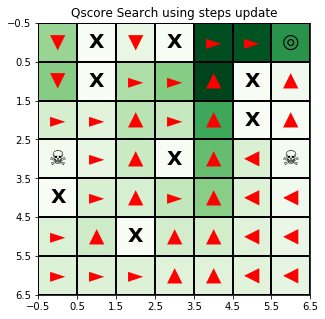

In [762]:
############### Method 1 ########################
visitedPath = []
useEligibility=True
s1 = RL_SearchAgent(p1, alpha = 0.1, gamma = 0.90, initialState = (1,1), useEligibility=useEligibility)

visitedPath, QscoreDiffHist = s1.trainModelbyTemporalDifference(epoche=500, offPolicyThreshold=0.2)        
displayRLMaze(p1, s1, visitedPath,'Qscore Search using steps update')

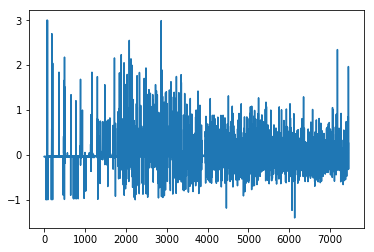

In [763]:
plt.plot(QscoreDiffHist)

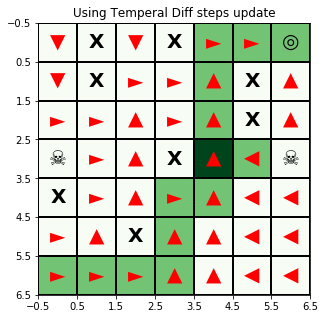

In [764]:
showSearchPolicy(p1, s1, title='Using Temperal Diff steps update')

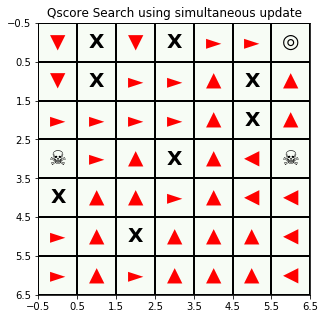

In [765]:
############### Method 2 ########################
s2 = RL_SearchAgent(p1, gamma=0.90, initialState = (1,1))
s2.trainModelBellEquation(epoche=300, offPolicyThreshold=0.0) 
#since we update all possible states, we might not need off policy in this case
displayRLMaze(p1, s2, [],'Qscore Search using simultaneous update')
# Note that there is no path in this concept because all states are updated in an epoch 

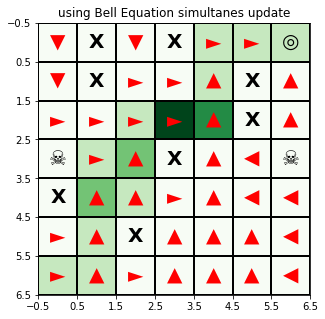

In [766]:
showSearchPolicy(p2, s2, title='using Bell Equation simultanes update')

### Learning Summary ###
<ul>
<li>BFS, DFS and Astar Search are basically planning algorithm. Everything has to be known in advance before the agent actually takes commitment to move. Reinforcement learning however assume a discovery mode where rewards and actions are not available to be seen beyond the current stage. The agent has to explore the environment by itself.
<li>Compared to BFS, DFS, Astar Search etc, Reinforcement Learning usually takes a longer time to find a "policy". But once a policy is found, it can almost solve any solution on the maze. And there is no need to do additional training once a policy is identified as the policy is memorized in the qScore.
<li>It is sometimes quite difficult to efficiently propagate utility values from a single state to others if the maze is big. Consider a maze of 7x7, it took a several a few hundreds or even a thousand of epoches (from initial state to goal) to train the model until it stablize (ie wont give random results). I found that shuffling the order of list of actions for method 1 or shuffling the order of states for method 2 could help.
<li>Method 1, temporal difference, which is taught in youtube and use a learning rate approach to update the difference between expected Qscore and the current Qscore out to be quite reliable. The qScore were updated using a step by step simulation approach. The qScore of a (state, action) will continue to update its value every time it is visited. However the propagation takes time and it could easily take up thousands of epoche (one complete trial from the random starting state to goal state) to train. The agent need time to eventually find its way to goal state and it can only propagate back the utility if it revisits the path states several times which takes a 7x7 maze long time to train. Also this method used simulation instead of calculation to take care of the expected value of probabilistic moves part and because of this, the true qScore takes even a longer time to converge because it has to explore all different options of actions leading to different results many times PLUS having to experience the probabilistic nature of the model.
<li>Later on I learned a method using eligibility to update the Qscore/Values/Utitlity of states, I used it and implemented it as an optional parameter to turn on and off in Method 1. It turned out to be working quite well. The propagation seems faster. I guess mainly because the eligibility force updates to affect all vis
<li>Seems that an off policy threshold of about 0.1-0.2 is the best for Method 1. Note that we introduce off policy only when it is simulating the choice of next state. We dont do that when we calculate the qScore for a given state and identified next action.
<li>A few different trials were made to implement method 2. Once it is done it is fairly fast in terms of converging. After a few hundred rounds of epoches (update all states once), the policy takes shape. Method consider the expected utility of different moves in the calculation of utlility while method assume just the state it ended in and allow probabilitistic outcome when doing the simulation so that the ultimate trained values would take into accounts of the probabilistic nature of the moves. It also update all states given a time period and is not taking a step approach. Because of these, the whole process seems to converge much faster. Compare to method two, method one is more uncertain and hence takes longer time to exploit all possibilities not to mention to allow values to propagate back efficiently.
</ul>